How is MNIST only providing the training and the test sets? What about the validation?

In order to perform cross-study comparison of model performance it makes a lot of sense to have a single test set for benchmarking. This way, different investigators can compare their respective models in an "apples to apples" manner. The test set is tested only once, as already mentioned, and is in a practical sense the final arbiter of model performance.

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import math 
from tqdm import tqdm
import sys
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import os
from sklearn.metrics import accuracy_score

##To get different random model weights

In [2]:
#https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


In [3]:
set_seed()

Random seed set as 42


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



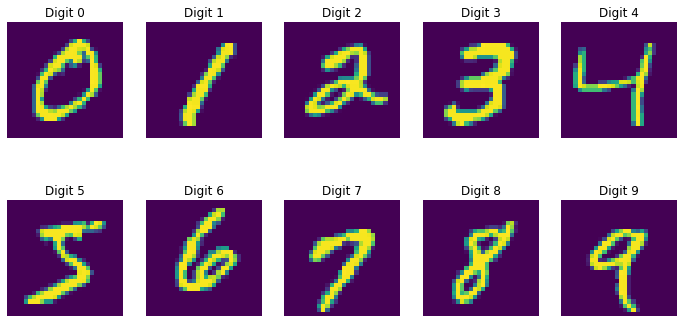

In [4]:
# Define the digits to print original images for
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Load MNIST dataset
mnist_dataset = MNIST(root='data/', download=True)

# Print original images for each digit
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    digit_indices = np.where(np.array(mnist_dataset.targets) == digits[i])[0]
    img = mnist_dataset.data[digit_indices[0]].numpy()
    ax.imshow(img)
    ax.set_title(f"Digit {i}")
    ax.axis('off')
plt.show()


In [ ]:
all_noise_maps.shape

(9786, 28, 28)

In [ ]:
mnist_dataset = MNIST(root='data/',train=False, download=True)
mnist_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test

#Question 3A: Classification image for each digit by white noise equation. First define a function for all the noise images.Then do a loop over for all the images to average them.

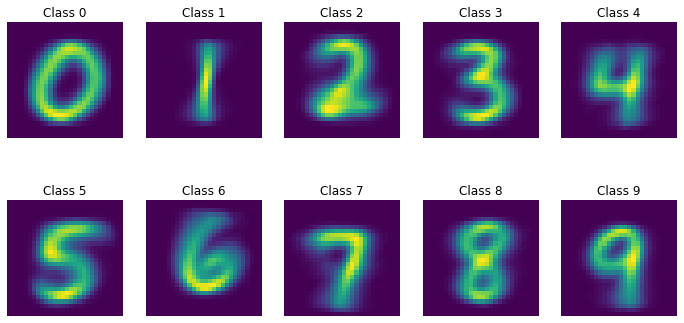

In [5]:
# Define the gamma value
gamma = 0.2

# Define the number of samples and image shape
n_samples = 500
img_shape = (28, 28)

# Define the digits to generate noise maps for
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def generate_noise_maps_per_digit(digit, n_samples, gamma, img_shape=(28, 28)):
    noise_maps = []
    mnist_dataset = MNIST(root='data/',train=False, download=True)
    digit_indices = np.where(np.array(mnist_dataset.targets) == digit)[0]
    digit_indices = digit_indices[:n_samples]
    for idx in digit_indices:
        # Get original image
        img = mnist_dataset.data[idx].numpy()
        # Generate random noise
        noise = np.random.randn(*img_shape)
        # Combine noise with original image
        noisy_img = gamma * noise + (1 - gamma) * img
        noise_maps.append(noisy_img)
    return np.array(noise_maps)

# Generate noise maps for each digit and average them
noise_maps=[]
avgd_noise_maps = []
for digit in digits:
    digit_noise_maps = generate_noise_maps_per_digit(digit, n_samples, gamma, img_shape=(28,28))
    avg_noise_map = np.mean(digit_noise_maps, axis=0)
    avgd_noise_maps.append(avg_noise_map)
    noise_maps.append(digit_noise_maps)

all_noise_maps = np.concatenate(noise_maps)
    

# Plot the noise maps
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(avgd_noise_maps[i])
    ax.set_title(f"Class {i}")
    ax.axis('off')
plt.show()


In [ ]:
all_noise_maps.shape

(9786, 28, 28)

#This is the noise at the background without MNIST digits. 

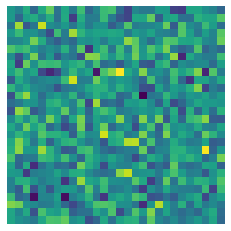

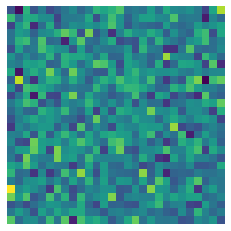

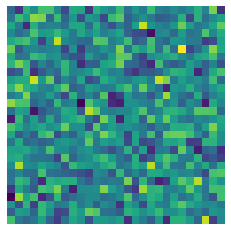

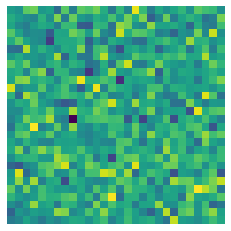

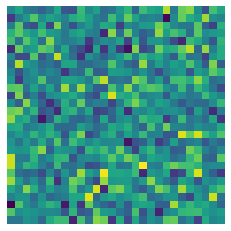

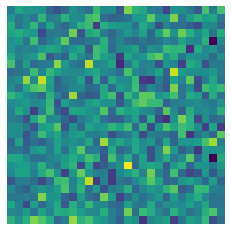

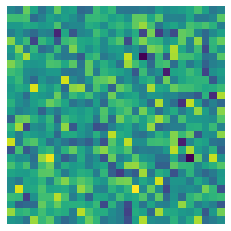

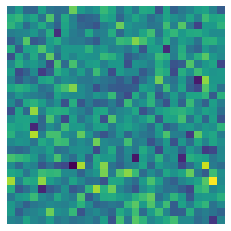

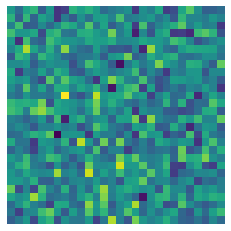

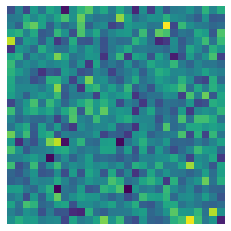

In [6]:
def generate_noise_maps(n_samples, gamma, img_shape=(28, 28)):
    background_noise_maps = []
    for _ in range(n_samples):
        # Generate random noise
        noise = np.random.randn(*img_shape)
        # Combine noise with original image
        noisy_img = gamma * noise + (1 - gamma) * np.ones(img_shape)
        background_noise_maps.append(noisy_img)
    return np.array(background_noise_maps)

# assuming `noisy_images` is a list of numpy arrays with shape (28, 28)
for i in range(len(generate_noise_maps(10,0.4, img_shape=(28, 28)))):
    fig, ax = plt.subplots()
    ax.imshow(generate_noise_maps(10,0.1, img_shape=(28, 28))[i])
    ax.axis('off')
    plt.show()



#Train the model and test on MNIST test dataset 

In [7]:
# Set device to CPU
device = torch.device('cpu')

# Define transformations for the data
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the training and test datasets
train_dataset = datasets.MNIST('data/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data/', train=False, download=True, transform=transform)

# Create data loaders for the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Move data and model to device (CUDA or CPU)
train_loader = train_loader

# set random seed
#torch.manual_seed(123)

# define the model architecture
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(20, 50, kernel_size=5)
        self.fc1 = torch.nn.Linear(4*4*50, 500)
        self.fc2 = torch.nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    
model = Model()
    
# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3) 

# define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# set the number of epochs
EPOCHS = 20

# create empty list to store the losses for each batch
losses = []

# initialize best accuracy to zero
best_accuracy = 0

# train the model
for epoch in range(EPOCHS):
    # set the model to train mode
    model.train()

    # loop over the batches in the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cpu(), target.cpu()
        # move the data to the device
        #data, target = data.to(device), target.to(device)

        # zero out the gradients
        optimizer.zero_grad()

        # forward pass
        y_pred = model(data)

        # calculate the loss
        loss = loss_fn(y_pred, target)

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()

        # save the loss for this batch
        losses.append(loss.item())

    # evaluate the model on the test set
    model.eval()

    # create empty list to store the predictions
    predictions = []

    # loop over the batches in the test set
    for data, target in test_loader:
        # move the data to the device
        data = data.cpu()
        target = target.cpu()

        # forward pass
        #output = model([:,None,...])[0]
        #output = model(data.unsqueeze(1))[0]
        output = model(data)


        # get the predicted class
        #pred = output.argmax(dim=1, keepdim=True)
        
        pred = output.data.max(1)[1]
        d = pred.eq(target.data).cpu()
        accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

        # save the predictions
        predictions.append(pred.cpu().numpy())

    # concatenate the predictions into a single array
    predictions = np.concatenate(predictions)

    # calculate the accuracy
    test_targets = test_loader.dataset.targets.numpy()
    accuracy = np.mean(predictions == test_targets)

    # print the loss and accuracy for this epoch
    print(f"Epoch {epoch+1}/{EPOCHS}, loss: {losses[-1]:.4f}, accuracy: {accuracy:.4f}")

    # save the model if it has the best accuracy so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "best_model.pt")
        print("Best model saved!")



Epoch 1/20, loss: 0.0225, accuracy: 0.9856
Best model saved!
Epoch 2/20, loss: 0.0000, accuracy: 0.9896
Best model saved!
Epoch 3/20, loss: 0.0001, accuracy: 0.9904
Best model saved!
Epoch 4/20, loss: 0.0058, accuracy: 0.9900
Epoch 5/20, loss: 0.0096, accuracy: 0.9916
Best model saved!
Epoch 6/20, loss: 0.0021, accuracy: 0.9890
Epoch 7/20, loss: 0.0000, accuracy: 0.9900
Epoch 8/20, loss: 0.0000, accuracy: 0.9909
Epoch 9/20, loss: 0.0069, accuracy: 0.9914
Epoch 10/20, loss: 0.0000, accuracy: 0.9922
Best model saved!
Epoch 11/20, loss: 0.0279, accuracy: 0.9915
Epoch 12/20, loss: 0.0000, accuracy: 0.9913
Epoch 13/20, loss: 0.0513, accuracy: 0.9910
Epoch 14/20, loss: 0.0000, accuracy: 0.9912
Epoch 15/20, loss: 0.0000, accuracy: 0.9930
Best model saved!
Epoch 16/20, loss: 0.0000, accuracy: 0.9902
Epoch 17/20, loss: 0.0000, accuracy: 0.9935
Best model saved!
Epoch 18/20, loss: 0.0000, accuracy: 0.9874
Epoch 19/20, loss: 0.0237, accuracy: 0.9926
Epoch 20/20, loss: 0.0000, accuracy: 0.9903


#3B Feed the average noise map back in to the CNN and report which class they are classified as

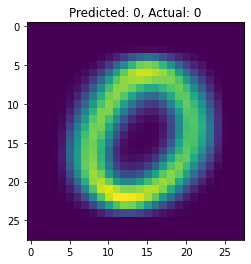

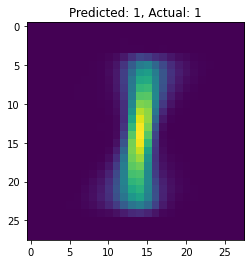

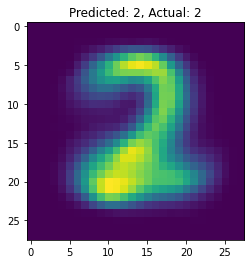

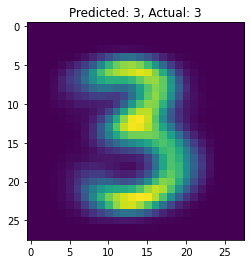

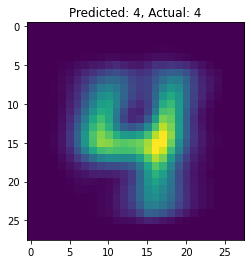

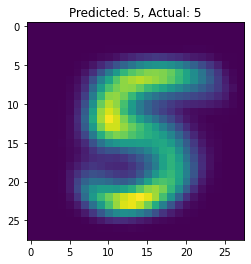

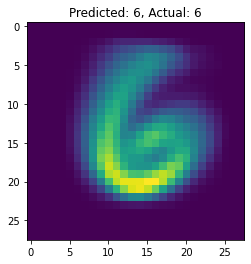

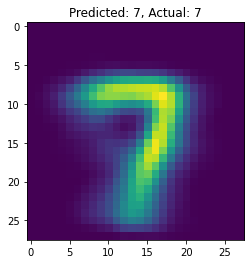

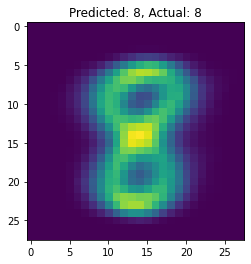

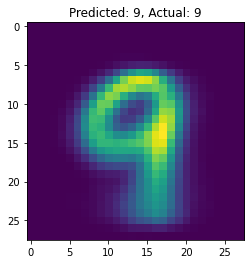

In [8]:
# predict on averaged image
# Define the number of samples and image shape
n_samples = 500
img_shape = (28, 28)

# Define the digits to generate noise maps for
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Define the threshold for predictions
threshold = 0.7

for digit in digits:
    test_tensor = torch.from_numpy((avgd_noise_maps[digit])[None,...]).type(torch.FloatTensor)
    output = model(test_tensor)
    
    # Get the predicted class and corresponding probability
    probs = torch.softmax(output, dim=1)
    max_prob, pred_class = torch.max(probs, dim=1)
    
    # Filter out predictions with low confidence
    if max_prob >= threshold:
        # Convert the noise map to an image
        noise_map =avgd_noise_maps[digit]
        img = (noise_map * 255)
    
        # Display the image with the predicted and actual class labels
        plt.imshow(img)
        plt.title(f"Predicted: {pred_class.item()}, Actual: {digit}")
        plt.show()

#3C  Note: Below is the confusion matrix for whole **MNIST dataset** as a test data

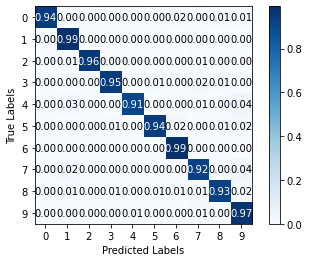

In [9]:
# Define the transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Load the test dataset
test_dataset = datasets.MNIST('data/', train=False, download=True, transform=transform)

# Create data loader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


# Set the model to evaluation mode
model.eval()

# Get the true labels and predicted labels for the test set
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels += labels.numpy().tolist()
        predicted_labels += predicted.numpy().tolist()

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Plot the confusion matrix
plt.imshow(cm, cmap='Blues')
plt.colorbar()

# Add labels to the plot
classes = [str(i) for i in range(10)]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add values to the plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

# Show the plot
plt.show()


In [10]:
# assuming you have y_true and y_pred from your model
report = classification_report(true_labels, predicted_labels)

print(report)

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       980
           1       0.92      0.99      0.96      1135
           2       0.98      0.96      0.97      1032
           3       0.97      0.95      0.96      1010
           4       0.98      0.91      0.95       982
           5       0.97      0.94      0.95       892
           6       0.95      0.99      0.97       958
           7       0.94      0.92      0.93      1028
           8       0.96      0.93      0.95       974
           9       0.88      0.97      0.92      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



#3C Using all the noise maps as a classifier and report the accuracy scores across all classes with confusion matrices. 

Accuracy: 0.9755951190238048


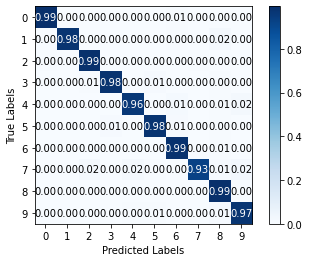

In [11]:
# Define the threshold for predictions
threshold = 0.7

# Set the model to evaluation mode
model.eval()

# Get the true labels and predicted labels for the noise maps
true_labels = []
predicted_labels = []

with torch.no_grad():
    for i in range(all_noise_maps.shape[0]):
        test_tensor = torch.from_numpy(all_noise_maps[i][None,...]).type(torch.FloatTensor)
        outputs = model(test_tensor)
        prob = torch.softmax(outputs, dim=1)
        max_prob, predicted_label = torch.max(prob.data, 1)
        if max_prob > threshold:
            true_label = i // n_samples  # Get the true label from the digit index
            true_labels.append(true_label)
            predicted_labels.append(predicted_label.item())

# Calculate the accuracy score
accuracy = accuracy_score(true_labels, predicted_labels)
print('Accuracy:', accuracy)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Plot the confusion matrix
plt.imshow(cm, cmap='Blues')
plt.colorbar()

# Add labels to the plot
classes = [str(i) for i in range(10)]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add values to the plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

# Show the plot
plt.show()


In [12]:
# assuming you have y_true and y_pred from your model
report = classification_report(true_labels, predicted_labels)

print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       500
           1       1.00      0.98      0.99       500
           2       0.97      0.99      0.98       500
           3       0.99      0.98      0.98       500
           4       0.98      0.96      0.97       500
           5       0.98      0.98      0.98       499
           6       0.96      0.99      0.97       500
           7       1.00      0.93      0.96       500
           8       0.95      0.99      0.97       500
           9       0.95      0.97      0.96       500

    accuracy                           0.98      4999
   macro avg       0.98      0.98      0.98      4999
weighted avg       0.98      0.98      0.98      4999



#EXTRA MATERIAL FROM THE ARTICLE GITHUB

torch.Size([20, 1, 5, 5])


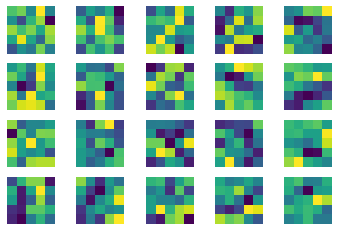

In [13]:
# plot conv1 wights
w_ = model.state_dict()['conv1.weight']
print(w_.shape)
for i in range(w_.shape[0]):
    plt.subplot(4, 5, i+1)
    plt.axis('off')
    to_show = w_[i][0].cpu().numpy()
    plt.imshow((to_show - to_show.min())/(to_show.max() - to_show.min()))
plt.show()

In [15]:
# [filter size, stride, padding]
convnet =   [[5,1,0], [2,2,0], [5,1,0], [2,2,0]]
layer_names = ['conv1','pool1','conv2','pool2']
imsize = 28

def outFromIn(conv, layerIn):
    n_in = layerIn[0]
    j_in = layerIn[1]
    r_in = layerIn[2]
    start_in = layerIn[3]
    
    k = conv[0]
    s = conv[1]
    p = conv[2]
    
    n_out = (n_in - k + 2*p)//s + 1
    actualP = (n_out-1)*s - n_in + k
    pR = math.ceil(actualP/2)
    pL = math.floor(actualP/2)
    
    j_out = j_in * s
    r_out = r_in + (k - 1)*j_in
    start_out = start_in + ((k-1)/2 - pL)*j_in
    return n_out, j_out, r_out, start_out
  
def printLayer(layer, layer_name):
    print(layer_name + ":")
    print("\t n features: %s \n \t jump: %s \n \t receptive size: %s \t start: %s " % (
        layer[0], layer[1], layer[2], layer[3]))
    
layerInfos = []
#first layer is the data layer (image) with n_0 = image size; j_0 = 1; r_0 = 1; and start_0 = 0.5
print ("-------Net summary------")
currentLayer = [imsize, 1, 1, 0.5]
printLayer(currentLayer, "input image")
for i in range(len(convnet)):
    currentLayer = outFromIn(convnet[i], currentLayer)
    layerInfos.append(currentLayer)
    printLayer(currentLayer, layer_names[i])
print ("------------------------")

-------Net summary------
input image:
	 n features: 28 
 	 jump: 1 
 	 receptive size: 1 	 start: 0.5 
conv1:
	 n features: 24 
 	 jump: 1 
 	 receptive size: 5 	 start: 2.5 
pool1:
	 n features: 12 
 	 jump: 2 
 	 receptive size: 6 	 start: 3.0 
conv2:
	 n features: 8 
 	 jump: 2 
 	 receptive size: 14 	 start: 7.0 
pool2:
	 n features: 4 
 	 jump: 4 
 	 receptive size: 16 	 start: 8.0 
------------------------


In [ ]:
# helper block for checking particular neuron's rf position
# start center, jump, rf (receptive field) size, feature map size, channel_num
rf_info = {'conv1':[2.5, 1, 5, 24, 20], 'conv2':[7, 2, 14, 8, 50]}

key = 'conv2'
p_rf = rf_info[key][2]
p_feat = rf_info[key][3]

for i in range(p_feat):
    for j in range(p_feat):
        center_i = rf_info[key][0] + i * rf_info[key][1]
        center_j = rf_info[key][0] + j * rf_info[key][1]
        left = int(center_i - p_rf / 2)
        right = int(center_i + p_rf / 2)
        up = int(center_j - p_rf / 2)
        bottom = int(center_j + p_rf / 2)
        
        print('({},{}): {}, {}, {}, {}'.format(i, j, left, right, up, bottom))

(0,0): 0, 14, 0, 14
(0,1): 0, 14, 2, 16
(0,2): 0, 14, 4, 18
(0,3): 0, 14, 6, 20
(0,4): 0, 14, 8, 22
(0,5): 0, 14, 10, 24
(0,6): 0, 14, 12, 26
(0,7): 0, 14, 14, 28
(1,0): 2, 16, 0, 14
(1,1): 2, 16, 2, 16
(1,2): 2, 16, 4, 18
(1,3): 2, 16, 6, 20
(1,4): 2, 16, 8, 22
(1,5): 2, 16, 10, 24
(1,6): 2, 16, 12, 26
(1,7): 2, 16, 14, 28
(2,0): 4, 18, 0, 14
(2,1): 4, 18, 2, 16
(2,2): 4, 18, 4, 18
(2,3): 4, 18, 6, 20
(2,4): 4, 18, 8, 22
(2,5): 4, 18, 10, 24
(2,6): 4, 18, 12, 26
(2,7): 4, 18, 14, 28
(3,0): 6, 20, 0, 14
(3,1): 6, 20, 2, 16
(3,2): 6, 20, 4, 18
(3,3): 6, 20, 6, 20
(3,4): 6, 20, 8, 22
(3,5): 6, 20, 10, 24
(3,6): 6, 20, 12, 26
(3,7): 6, 20, 14, 28
(4,0): 8, 22, 0, 14
(4,1): 8, 22, 2, 16
(4,2): 8, 22, 4, 18
(4,3): 8, 22, 6, 20
(4,4): 8, 22, 8, 22
(4,5): 8, 22, 10, 24
(4,6): 8, 22, 12, 26
(4,7): 8, 22, 14, 28
(5,0): 10, 24, 0, 14
(5,1): 10, 24, 2, 16
(5,2): 10, 24, 4, 18
(5,3): 10, 24, 6, 20
(5,4): 10, 24, 8, 22
(5,5): 10, 24, 10, 24
(5,6): 10, 24, 12, 26
(5,7): 10, 24, 14, 28
(6,0): 12, 26,